# Hopfield Net

In [1]:
import numpy as np

In [2]:
# Implementation for asynchronous Hopfield neural network
# Note: memory capacity ≃ 0.14*nodes
class Hopfield_Neural_Network:
    def __init__(self,nodes,iterations=100,weights=None):
        self.nodes = nodes
        self.iterations = iterations
        try:
            if weights == None:
                self.weights = np.zeros((nodes,nodes))
        except ValueError:
            self.weights = weights
    
    def store(self,input):
        dW = np.outer(input.transpose(),input)
        np.fill_diagonal(dW,0)
        self.weights += dW
        
    def recall(self,input):
        update_sequence = np.random.choice(self.nodes, self.iterations)
        for node in update_sequence:
            input[node] = np.sign(np.inner(input,self.weights[:,node]))
        return input
    
    def setIter(self,iter_):
        self.iterations = iter_
    
    def save_weights(self,filename):
        np.save(filename, self.weights)
        
    def load_weights(self,filename):
        weights = np.load(filename)
        if weights.shape == (self.nodes, self.nodes):
            self.weights = weights
        else:
            raise ValueError("Dimensions of specified weight array does not match network weight dimensions!")

In [3]:
hnn = Hopfield_Neural_Network(10)

# Data

### Matrices

In [4]:
import re

In [5]:
class matrix_expansion:
    
    def __init__(self,active_motors):
        self.active_motors = active_motors
        active_sensors = np.array(active_motors*2)
        active_sensors[len(active_motors):] += 14
        self.active_sensors = active_sensors
        self.shape = ()
        
    def load_from_file(self,filename):
        f = open(filename,"r")
        matrix = f.read()
        f.close()
        matrix = re.split(",NEW_ROW,",matrix)
        matrix.pop()
        matrix = np.array([np.array(re.split(",", row)).astype(np.float) for row in matrix])
        self.shape = matrix.shape
        return matrix
        
    def reduced_matrix(self,matrix):
        matrix = matrix[:,self.active_sensors][self.active_motors]
        return matrix
    
    def expanded_matrix(self,reduced_matrix):
        matrix = np.zeros(self.shape)
        flat = reduced_matrix.flatten()
        matrix = np.zeros((14,28))
        k = 0
        for i in active_motors:
            for j in active_sensors:
                matrix[i,j] = flat[k]
                k += 1
        return matrix

In [6]:
active_motors = [1,3,4,5,10,12]
expander = matrix_expansion(active_motors)

In [7]:
# Front back
filename = "/home/markus/dep/dep_matrices/front_back.dep"
fb_matrix = expander.load_from_file(filename)
fb_reduced = expander.reduced_matrix(fb_matrix)
#fb_expanded = expander.expanded_matrix(fb_reduced)

In [8]:
# Front side
filename = "/home/markus/dep/dep_matrices/front_side.dep"
fs_matrix = expander.load_from_file(filename)
fs_reduced = expander.reduced_matrix(fs_matrix)
#fs_expanded = expander.expanded_matrix(fs_reduced)

In [9]:
# Side down
filename = "/home/markus/dep/dep_matrices/side_down.dep"
sd_matrix = expander.load_from_file(filename)
sd_reduced = expander.reduced_matrix(sd_matrix)
#sd_expanded = expander.expanded_matrix(sd_reduced)

In [10]:
# Zero
zero_reduced = np.zeros(fb_reduced.shape)

In [11]:
matrices = {"fb": fb_reduced, "fs": fs_reduced, "sd": sd_reduced, "zero": zero_reduced}

### Transition points

In [12]:
behaviors = ["zero","fb","fs","sd"]
transitions = {("fb","fs"): [], ("fb","sd"): [], ("fs","fb"): [], ("fs","sd"): [], ("sd","fb"): [], ("sd","fs"): []}

# generate all transition combinations (including zero and "self-transitions")
#transitions = {}
#for behavior_1 in behaviors:
#    for behavior_2 in behaviors:
#        transitions[(behavior_1,behavior_2)] = []

#transitions_for_muscle_2 = -1.5 rad, positive velocity for all behaviors, except zero for which it is 0,0 

In [13]:
# need to get positions and velocities for fb, fs and sd at -1.5 going up, and set them for zero at 0

In [14]:
import pickle

In [15]:
fb = pickle.load(open("/home/markus/dep/dep_data/bases/fb.pickle","rb"))
fs = pickle.load(open("/home/markus/dep/dep_data/bases/fs.pickle","rb"))
sd = pickle.load(open("/home/markus/dep/dep_data/bases/sd.pickle", "rb"))
zero = []
for array in fb:
    zero.append(np.zeros(array.shape))

bases = {"fb": fb, "fs": fs, "sd": sd}#, "zero": zero}

In [16]:
# obtained from plot, time indices that meat transition_muscle_2 condition
fb_t = 124
fs_t = 126
sd_t = 117
zero_t = 0

In [17]:
# pos data
pos = {"fb": fb[0][fb_t][active_motors], "fs": fs[0][fs_t][active_motors], "sd": sd[0][sd_t][active_motors], "zero": zero[0][zero_t][active_motors]}
# vel data
vel = {"fb": fb[1][fb_t][active_motors], "fs": fs[1][fs_t][active_motors], "sd": sd[1][sd_t][active_motors], "zero": zero[1][zero_t][active_motors]}

### Brain ID

In [119]:
n = len(behaviors)
start = 0.0
width = 1.0/float(n)
brain_ranges = {}
for i in range(1,n+1):
    brain_ranges[behaviors[i-1]] = ((i-1)*width-start, i*width-start)
brain_id = {}
for behavior in behaviors:
    brain_id[behavior] = (brain_ranges[behavior][0]+brain_ranges[behavior][1])/2
# "zero = [0.0,0.25], "fb" = [0.25,0.5], "fs" = [0.5, 0.75], "sd" = [0.75,1.00]
#brain_id = {"zero": 0.125, "fb": 0.375, "fs": 0.625, "sd": 0.875}

# Encoding

In [19]:
# HTM SDR Scalar Encoder
# Input: Scalar
# Parameters: n - number of units, w - bits used to represent signal (width), b - buckets (i.e. resolution), 
#             min - minimum value of input (inclusive), max - maximum input value (inclusive)
class scalar_sdr:
    
    def __init__(self, b, w, min_, max_, shape=0):
        if type(b) != int or type(w) != int or type(min_) != float or type(max_) != float:
            raise TypeError("b - buckets must be int, w - width must be int, min_ must be float and max_ must be float")
        self.b = b # must be int
        self.w = w # must be int
        self.min = min_ # must be float
        self.max = max_ # must be float
        self.n = b+w-1 # number of units for encoding
        self.ndarray_shape = shape
        
    def encode(self,input_):
        if input_ > self.max or input_ < self.min:
            raise ValueError("Input outside encoder range!")
        if type(input_) != float:
            raise TypeError("Input must be float!")
        output = np.zeros(self.n)-1
        index = int((input_-self.min)/(self.max-self.min)*self.b)
        output[index:index+self.w] = 1
        return output
    
    def encode_ndarray(self,input_):
        if input_.shape != self.ndarray_shape:
            raise ValueError("Input dimensions do not match specified encoder dimensions!")
        output = []
        for i in np.nditer(input_, order='K'):
            output.append(self.encode(float(i)))
        return np.array(output)
    '''
    def decode(self,input_):
        if len(input_) != self.n: # or len(np.nonzero(input_+1)[0]) != self.w: <-- Can't have since the network is not guaranteed to produce this by any means!!!
            raise TypeError("Input does not correspond to encoder encoded data!")
        # output = np.nonzero(input_+1)[0][0]/float(self.b)*(self.max-self.min)+self.min <-- This doesn't work really since bits can randomly fire, taking the average is a more reasonable decoding
        median = np.median(np.nonzero(input_+1)[0])            
        try:
            output = int(median-float(self.w)/2.0)/float(self.b)*(self.max-self.min)+self.min # i.e. figure out center (median more outlier resistant than mean) and subtract width/2
        except ValueError:
            output = None
        return output
    '''
    def decode(self,input_):
        if len(input_) != self.n: # or len(np.nonzero(input_+1)[0]) != self.w: <-- Can't have since the network is not guaranteed to produce this by any means!!!
            raise TypeError("Input does not correspond to encoder encoded data!")
        if len(np.nonzero(input_+1)[0]) == 0:
            return np.nan
        max_ = 0
        output = 0.0
        for i in range(self.b):
            x = np.zeros(self.n)-1
            x[i:i+self.w] = 1
            score = np.sum(np.array(x)*input_)
            if score > max_:
                max_ = score
                output = float(i)/float(self.b)*(self.max-self.min)+self.min
        return output
            
    def decode_ndarray(self,input_):
        if input_.shape != (reduce(lambda x, y: x*y, self.ndarray_shape)*self.n,): 
            raise ValueError("Input dimensions do not match specified encoder dimensions!")
        input_ = input_.reshape(self.ndarray_shape+(self.n,))
        output = []
        for i in np.ndindex(self.ndarray_shape):
            output.append(self.decode(input_[i]))
        output = np.array(output).reshape(self.ndarray_shape)
        return output
    
    def set_ndarray_shape(self,shape):
        if type(shape) != tuple:
            raise TypeError("Must provide tuple of array dimensions!")
        self.ndarray_shape = shape

In [20]:
#matrix_encoder = scalar_sdr(60,21,-0.3,0.3,(6,12))
#pos_encoder = scalar_sdr(500,21,-100000.0,100000.0,(6,))
#vel_encoder = scalar_sdr(200,41,-70.0,70.0,(6,))
#brain_encoder = scalar_sdr(1000,101,0.0,1.0)

# Training data

In [144]:
# TODO: 
# - add transition to zero
# - cleanup data generation using more general sense of transition (including zero and auto)

In [145]:
# So what data do we need? What system output do we want? What are the conditions?
# Overall input/output vectors (encoded): [state_matrix,matrix,motor_pos,motor_vel,brain_sig]
# Note: 
#      state matrix -- a sensory value from the dep node
#      motor_pos and motor_vel -- sensory values from motors
#      brain_sig -- single scalar input from brain
#      matrix -- the only output of the system, sending a DEP matrix to the dep node

In [146]:
# Scenario 1: system stationary i.e. zeros (technically transition from zero)
# Input: [state_matrix = 0, matrix = 0, motor_pos = 0, motor_vel = 0, brain_id = brain_id]
# Desired output: [state_matrix = 0, matrix = matrices[brain_id], motor_pos = 0, motor_vel = 0, brain_sig = brain_id]
# Training data = desired output for each brain_id

In [147]:
stationary_data = {}
for id_ in brain_id:
    stationary_data[id_] = np.array([])
    
    state_matrix = matrix_encoder.encode_ndarray(matrices["zero"]) # Note: this is not changed since it is sensory
    stationary_data[id_] = np.append(stationary_data[id_],state_matrix.flatten())
    
    matrix = matrix_encoder.encode_ndarray(matrices[id_])
    stationary_data[id_] = np.append(stationary_data[id_], matrix.flatten())
    
    motor_pos = pos_encoder.encode_ndarray(pos["zero"])
    stationary_data[id_] = np.append(stationary_data[id_],motor_pos.flatten())
    
    motor_vel = vel_encoder.encode_ndarray(vel["zero"])
    stationary_data[id_] = np.append(stationary_data[id_],motor_vel.flatten())
    
    brain_sig = brain_encoder.encode(brain_id[id_])
    stationary_data[id_] = np.append(stationary_data[id_],brain_sig.flatten())


In [148]:
# Scenario 2: transition from one behavior to another based on the input brain_id at the correct motor_pos and motor_vel
# Input: [state_matrix = state_matrix, matrix = 0, motor_pos = motor_pos, motor_vel = motor_vel, brain_sig = brain_id]

# Desired output: if system state equals the transition point, transition, else don't i.e. requires "positive" and "negative examples"

# if motor_pos ~= pos[brain_id[ and motor_vel ~= vel[brain_id]:
#     state_matrix = state_matrix, matrix = matrix[brain_id], motor_pos = motor_pos, motor_vel = motor_vel, brain_sig = brain_id]
# else:
#    state_matrix = state_matrix, matrix = state_matrix, motor_pos = motor_pos, motor_vel = motor_vel, brain_sig = brain_id]

# Training data: single positive example for each transition pair, lots of negatives examples for different motor_pos and motor_vel

In [149]:
# transition point positive examples
transitions_positive_data = {}
for transition in transitions:
    transitions_positive_data[transition] = []
    
    m0 = matrix_encoder.encode_ndarray(matrices[transition[0]])
    transitions_positive_data[transition] = np.append(transitions_positive_data[transition], m0.flatten())
    
    m1 = matrix_encoder.encode_ndarray(matrices[transition[1]])
    transitions_positive_data[transition] = np.append(transitions_positive_data[transition], m1.flatten())
    
    p = pos_encoder.encode_ndarray(pos[transition[0]])
    transitions_positive_data[transition] = np.append(transitions_positive_data[transition], p.flatten())
    
    v = vel_encoder.encode_ndarray(vel[transition[0]])
    transitions_positive_data[transition] = np.append(transitions_positive_data[transition], v.flatten())
    
    brain_sig = brain_encoder.encode(brain_id[transition[1]])
    transitions_positive_data[transition] = np.append(transitions_positive_data[transition], brain_sig.flatten())

In [150]:
# transition point negative examples

In [151]:
# setup negative motor_pos and motor_vel data

neg_pos = {"fb": [], "fs": [], "sd": []}
neg_vel = {"fb": [], "fs": [], "sd": []}

steps = [0, 12, 24, 36, 48, 60, 72, 84, 96, 108]

for key in bases:
    for i in steps:
        neg_pos[key].append(bases[key][0][i][active_motors])
        neg_vel[key].append(bases[key][1][i][active_motors])

In [152]:
# obtain negative examples
transitions_negative_data = {}
for transition in transitions:
    transitions_negative_data[transition] = []
    for i in range(len(neg_pos[transition[0]])):
        temp = np.array([])
        
        m0 = matrix_encoder.encode_ndarray(matrices[transition[0]])
        temp = np.append(temp, m0.flatten())

        m1 = m0
        temp = np.append(temp, m1.flatten())

        p = pos_encoder.encode_ndarray(neg_pos[transition[0]][i])
        temp = np.append(temp, p.flatten())

        v = vel_encoder.encode_ndarray(neg_vel[transition[0]][i])
        temp = np.append(temp, v.flatten())

        brain_sig = brain_encoder.encode(brain_id[transition[1]])
        temp = np.append(temp, brain_sig.flatten())
        
        transitions_negative_data[transition].append(temp)

In [153]:
# Scenario 3: keep situation the same, active high brain signal (technically transitioning from self)
# Input: [state_matrix = state_matrix[brain_id], matrix = 0, motor_pos = motor_pos, motor_vel = motor_vel, brain_sig = brain_id]
# Desired output: [state_matrix = state_matrix[brain_id], matrix = matrix[brain_id], motor_pos = motor_pos, motor_vel = motor_vel, brain_sig = brain_id]
# Training data: Desired output over motor_pos and motor_vel range

maintain = {}
for id_ in matrices:
    if id_ != "zero":
        maintain[id_] = []
        for i in range(0,len(bases[id_][0]),12):
            temp = np.array([])
            m0 = matrix_encoder.encode_ndarray(matrices[id_])
            temp = np.append(temp, m0.flatten())

            m1 = m0
            temp = np.append(temp, m1.flatten())

            p = pos_encoder.encode_ndarray(bases[key][0][i][active_motors])
            temp = np.append(temp, p.flatten())

            v = vel_encoder.encode_ndarray(bases[key][1][i][active_motors])
            temp = np.append(temp, v.flatten())

            braing_sig = brain_encoder.encode(brain_id[id_])
            temp = np.append(temp, braing_sig.flatten())
            maintain[id_].append(temp)

In [154]:
# Scenario 4: shutdown (transition to zero)
# Input: [state_matrix = state_matrix, matrix = 0, motor_pos = motor_pos, motor_vel = motor_vel, brain_sig = zero]
# Desired output: [state_matrix = state_matrox, matrix = 0, motor_pos = motor_pos, motor_vel = motor_vel, brain_sig = zero]
# Training data: Desired output over motor_pos and motor_vel range

shutdown = {}
for id_ in matrices:
    if id_ != "zero":
        shutdown[id_] = []
        for i in range(0,len(bases[id_][0]),12):
            temp = np.array([])
            m0 = matrix_encoder.encode_ndarray(matrices[id_])
            temp = np.append(temp, m0.flatten())

            m1 = matrix_encoder.encode_ndarray(matrices["zero"])
            temp = np.append(temp, m1.flatten())

            p = pos_encoder.encode_ndarray(bases[key][0][i][active_motors])
            temp = np.append(temp, p.flatten())

            v = vel_encoder.encode_ndarray(bases[key][1][i][active_motors])
            temp = np.append(temp, v.flatten())

            braing_sig = brain_encoder.encode(brain_id["zero"])
            temp = np.append(temp, braing_sig.flatten())
            shutdown[id_].append(temp)

# Train Hopfield

In [174]:
hnn = Hopfield_Neural_Network(17180,200)

In [175]:
# stationary data
for item in stationary_data:
    hnn.store(stationary_data[item])

In [176]:
# positive transitions data
for item in transitions_positive_data:
    hnn.store(transitions_positive_data[item])

In [177]:
# negative transitions
for key in transitions_negative_data:
    for item in transitions_negative_data[key]:
        hnn.store(item)

In [178]:
# maintain status
for key in maintain:
    for item in maintain[key]:
        hnn.store(item)

In [179]:
# shutdown data
for key in shutdown:
    for item in maintain[key]:
        hnn.store(item)

In [180]:
# save hnn weights
hnn.save_weights('hnn_weights')

# Testing

### 1. "Recall" matrices from complete matrix
### 1.1  Vary encoder buckets and width and investigate resulting error and processing times (store and recall)

In [21]:
import time
import pickle

In [132]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
buckets = [30,60,90,120,150,180,210,240,270,300]
widths = [11, 21, 31]
experiments = {}
for width in widths:
    for bucket in buckets:
        print "Buckets - %i, Width - %i" %(bucket,width)
        print "------------------------------------------------------------------------------"
        experiments[(bucket,width)] = {}
        # initialize encoder
        m_encoder = scalar_sdr(bucket,width,-0.25,0.25,(6,12))
        # initialize hopfield network
        nodes = m_encoder.n*reduce(lambda x, y: x*y, m_encoder.ndarray_shape)
        hnn = Hopfield_Neural_Network(nodes,10000)
        # store matrices in network
        for id_ in matrices:
            print("Id: %s" %id_)
            experiments[(bucket,width)][id_] = {}
            
            t0 = time.time()
            matrix = m_encoder.encode_ndarray(matrices[id_]).flatten()
            t1 = time.time()
            encoding_time = t1-t0
            experiments[(bucket,width)][id_]["encoding_time"] = encoding_time
            print("Encoding time: %f" %encoding_time)
            
            t0 = time.time()
            hnn.store(matrix)
            t1 = time.time()
            store_time = t1-t0
            experiments[(bucket,width)][id_]["storing_time"] = store_time
            print("Storing time: %f" %store_time)
            
            
        # recall matrices and store data for evaluation
        for id_ in matrices:
            
            t0 = time.time()
            mem = hnn.recall(m_encoder.encode_ndarray(matrices[id_]).flatten())
            t1 = time.time()
            recall_time = t1-t0
            experiments[(bucket,width)][id_]["recall_time"] = recall_time
            print("Recall time: %f" %recall_time)
            
            t0 = time.time()
            mem_decoded = m_encoder.decode_ndarray(mem)
            t1 = time.time()
            decode_time = t1-t0
            experiments[(bucket,width)][id_]["decode_time"] = recall_time
            print("Decode time: %f" %decode_time)
            
            experiments[(bucket,width)][id_]["mem_decoded"] = mem_decoded
            print("Mem decoded: ")
            print(np.array(mem_decoded))
            
            matrix_decoded = m_encoder.decode_ndarray(m_encoder.encode_ndarray(matrices[id_]).flatten())
            diff = mem_decoded-matrix_decoded
            experiments[(bucket,width)][id_]["diff"] = diff
            print("Diff: ")
            print(np.array(diff))
            
        print "------------------------------------------------------------------------------"
        
print "pickling experiment data"
pickle_out = open("experiments1.pickle","wb")
pickle.dump(experiments, pickle_out)
pickle_out.close()

Buckets - 30, Width - 11
------------------------------------------------------------------------------
Id: fb
Encoding time: 0.000568
Storing time: 0.036327
Id: fs
Encoding time: 0.000614
Storing time: 0.031066
Id: zero
Encoding time: 0.001033
Storing time: 0.029890
Id: sd
Encoding time: 0.000639
Storing time: 0.029311
Recall time: 0.301398
Decode time: 0.019025
Mem decoded: 
[[ 0.083  0.05  -0.117  0.083 -0.117 -0.15  -0.183 -0.183  0.167 -0.183
   0.183  0.183]
 [ 0.1    0.1    0.117 -0.133 -0.133  0.    -0.2   -0.167 -0.183  0.15
   0.15   0.   ]
 [-0.1    0.067  0.1   -0.1    0.1    0.133  0.167 -0.167 -0.183  0.167
  -0.2   -0.217]
 [ 0.083 -0.083 -0.117  0.083 -0.117 -0.15  -0.183  0.15   0.167 -0.183
   0.183  0.183]
 [-0.1   -0.083  0.083 -0.083  0.083  0.133  0.167  0.15  -0.183  0.167
  -0.2   -0.217]
 [-0.067  0.     0.067 -0.067  0.083  0.117  0.167  0.    -0.183  0.167
  -0.217 -0.233]]
Diff: 
[[ 0.     0.133 -0.017  0.     0.     0.     0.    -0.333  0.     0.     0.
  -

Storing time: 0.196751
Id: fs
Encoding time: 0.000582
Storing time: 0.177448
Id: zero
Encoding time: 0.000608
Storing time: 0.181862
Id: sd
Encoding time: 0.000542
Storing time: 0.186511
Recall time: 0.818608
Decode time: 0.057604
Mem decoded: 
[[ 0.1    0.072 -0.1    0.089 -0.117 -0.15  -0.178 -0.172  0.167 -0.172
   0.183  0.189]
 [ 0.111  0.106  0.117 -0.122 -0.122  0.133 -0.183 -0.161 -0.178  0.156
   0.156 -0.2  ]
 [-0.094  0.067  0.094 -0.094  0.106  0.139  0.167 -0.161 -0.172  0.172
  -0.2   -0.206]
 [ 0.089 -0.078 -0.106  0.089 -0.117 -0.15  -0.178  0.161  0.167 -0.172
   0.183  0.2  ]
 [-0.094 -0.083  0.083 -0.1    0.1    0.133  0.178  0.156 -0.178  0.178
  -0.206 -0.217]
 [-0.072  0.     0.067 -0.072  0.083  0.122  0.178 -0.161 -0.183  0.178
  -0.211 -0.228]]
Diff: 
[[ 0.011  0.15   0.     0.     0.     0.     0.    -0.333  0.     0.    -0.006
  -0.011]
 [ 0.228  0.006 -0.006  0.    -0.261 -0.022 -0.339  0.    -0.017  0.     0.333
  -0.022]
 [ 0.     0.     0.     0.     0.  

KeyboardInterrupt: 

In [ ]:
# Conclusion: system minima exist at stored memories

### 2. Recall matrices from partial matrix

    - Vary matrix portion that is provided to the input and identify systems capacity to complete the matrix

In [133]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
experiments = {}
buckets = [300]
widths = [31]
for width in widths:
    for bucket in buckets:
        print "Buckets - %i, Width - %i" %(bucket,width)
        print "------------------------------------------------------------------------------"
        experiments[(bucket,width)] = {}
        m_encoder = scalar_sdr(bucket,width,-0.25,0.25,(6,12))
        nodes = m_encoder.n*reduce(lambda x, y: x*y, m_encoder.ndarray_shape)
        hnn = Hopfield_Neural_Network(nodes,200)

        for id_ in matrices:
            matrix = m_encoder.encode_ndarray(matrices[id_]).flatten()
            hnn.store(matrix)
 
        portions = [95,90,85,80,75,70,65,60,55,50,45,40]
        for portion in portions:
            experiments[(bucket,width)][portion] = {}
            print "Portion - %f" %(portion)
            for id_ in matrices:
                experiments[(bucket,width)][portion][id_] = {}
                print("Id: %s" %id_)
                matrix = m_encoder.encode_ndarray(matrices[id_]).flatten()
                size = int(float(portion)/float(100)*len(matrix))
                flip_indices = np.random.choice(a=hnn.nodes,size=size,replace=False)
                print "number of flip_indices %i" %len(flip_indices)
                matrix[flip_indices] = -1

                mem = hnn.recall(matrix)

                mem_decoded = m_encoder.decode_ndarray(mem)
                #print("Mem decoded:")
                #print(mem_decoded)
                matrix_decoded = m_encoder.decode_ndarray(m_encoder.encode_ndarray(matrices[id_]).flatten())
                #print("Input matrix decoded: ")
                #print(matrix_decoded)
                diff = mem_decoded-matrix_decoded
                print("Diff:")
                print(diff)
                experiments[(bucket,width)][portion][id_]["diff"] = diff
                print("Largest error: "+str(np.max(abs(diff))))
                experiments[(bucket,width)][portion][id_]["max_error"] = np.max(abs(diff))
                print("Number of indices with error above 0.01: %i" %len(abs(diff)[abs(diff) > 0.01]))
                experiments[(bucket,width)][portion][id_]["num_errors"] = len(abs(diff)[abs(diff) > 0.01])
        print "------------------------------------------------------------------------------"

Buckets - 300, Width - 31
------------------------------------------------------------------------------


KeyboardInterrupt: 

In [84]:
#print "pickling experiment data"
#pickle_out = open("experiments_1_2_portion_B300.pickle","wb")
#pickle.dump(experiments, pickle_out)
#pickle_out.close()

In [85]:
dicts = {}
portions = [95,90,85,80,75,70,65,60,55,50,45,40]
for (bucket,width) in experiments:
    portion_vs_max = []
    portion_vs_num = []
    for portion in portions:
        max_ = 0.0
        num_ = 0
        for id_ in experiments[(bucket,width)][portion]:
            if experiments[(bucket,width)][portion][id_]["max_error"] > max_:
                max_ = experiments[(bucket,width)][portion][id_]["max_error"]
            if experiments[(bucket,width)][portion][id_]["num_errors"] > num_:
                num_ = experiments[(bucket,width)][portion][id_]["num_errors"]
        portion_vs_max.append(max_)
        portion_vs_num.append(num_)
    dicts[(bucket,width)] = []
    dicts[(bucket,width)].append(portion_vs_max)
    dicts[(bucket,width)].append(portion_vs_num)

In [86]:
dicts

{(240,
  21): [[0.0,
   0.0,
   0.0,
   0.029166666666666674,
   0.033333333333333354,
   0.025000000000000022,
   0.03125,
   0.022916666666666669,
   0.018749999999999989,
   0.020833333333333315,
   0.025000000000000022,
   0.018749999999999989], [39, 34, 33, 25, 21, 14, 12, 8, 9, 4, 2, 2]]}

In [ ]:
# What is the largest acceptable deviation such that DEP still performs the behavior?

### 2.2 Vary iterations to inspect impact on error and recall time

In [457]:
xs = [(210,21),(240,21)]
for x in xs:
    for key in experiments[x]:
        print key, np.max(abs(experiments[x][key]["diff"]))
    print

fb 0.00714285714286
fs 0.00952380952381
zero 0.111904761905
sd 0.0142857142857

fb 0.0104166666667
fs 0.00625
zero 0.00833333333333
sd 0.00625



    - Using buckets = 240, width = 21:
        - 240 buckets is the first size to producing maximum errors of <= 0.01 (rounded to 3 sig.fig.) with 10000 
        iterations for recalling from self, 
        - and width 21 to have more robustness against noise (as per suggestion of htm encoding paper) 
    - Note: later on it may be usefull to consider a larger width

In [23]:
iterations = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
m_encoder = scalar_sdr(240,21,-0.25,0.25,(6,12))

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

experiment_iterations = {}
portion = 70
nodes = m_encoder.n*reduce(lambda x, y: x*y, m_encoder.ndarray_shape)
hnn = Hopfield_Neural_Network(nodes)
# store matrices
for id_ in matrices:
    matrix = m_encoder.encode_ndarray(matrices[id_]).flatten()
    hnn.store(matrix)
for iter_ in iterations:
    print("Iterations - %i" %iter_)
    print "------------------------------------------------------------------------------"
    hnn.setIter(iter_)
    experiment_iterations[iter_] = {}
    # recall matrices and store data for evaluation
    for id_ in matrices:
        experiment_iterations[iter_][id_] = {}
        print("Id: %s" %id_)
        
        matrix = m_encoder.encode_ndarray(matrices[id_]).flatten()
        size = int(float(portion)/float(100)*len(matrix))
        flip_indices = np.random.choice(a=hnn.nodes,size=size,replace=False)
        matrix[flip_indices] = -1

        t0 = time.time()
        mem = hnn.recall(matrix)
        t1 = time.time()
        recall_time = t1-t0
        experiment_iterations[iter_][id_]["recall_time"] = recall_time
        print("Recall time: %f" %recall_time)

        t0 = time.time()
        mem_decoded = m_encoder.decode_ndarray(mem)
        t1 = time.time()
        decode_time = t1-t0
        experiment_iterations[iter_][id_]["decode_time"] = recall_time
        print("Decode time: %f" %decode_time)

        experiment_iterations[iter_][id_]["mem_decoded"] = mem_decoded
        #print("Mem decoded: ")
        #print(np.array(mem_decoded))

        matrix_decoded = m_encoder.decode_ndarray(m_encoder.encode_ndarray(matrices[id_]).flatten())
        diff = mem_decoded-matrix_decoded

        experiment_iterations[iter_][id_]["diff"] = diff
        print("Largest error: "+str(np.max(abs(diff))))
        print("Number of indices with error above 0.01: %i" %len(abs(diff)[abs(diff) > 0.01]))
        #print("Diff: ")
        #print(np.array(diff))
        
    print "------------------------------------------------------------------------------"
print "pickling experiment data"
pickle_out = open("experiment_iterations.pickle","wb")
pickle.dump(experiment_iterations, pickle_out)
pickle_out.close()

Iterations - 1
------------------------------------------------------------------------------
Id: fb
Recall time: 0.000674
Decode time: 0.168366
Largest error: 0.0375
Number of indices with error above 0.01: 9
Id: fs
Recall time: 0.000656
Decode time: 0.165562
Largest error: 0.0229166666667
Number of indices with error above 0.01: 10
Id: zero
Recall time: 0.000729
Decode time: 0.177017
Largest error: 0.0270833333333
Number of indices with error above 0.01: 11
Id: sd
Recall time: 0.001262
Decode time: 0.184766
Largest error: 0.0270833333333
Number of indices with error above 0.01: 13
------------------------------------------------------------------------------
Iterations - 2
------------------------------------------------------------------------------
Id: fb
Recall time: 0.001253
Decode time: 0.168449
Largest error: 0.0208333333333
Number of indices with error above 0.01: 9
Id: fs
Recall time: 0.001371
Decode time: 0.171695
Largest error: 0.0291666666667
Number of indices with error a

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater


Recall time: 1.041961
Decode time: 0.175099
Largest error: 0.1625
Number of indices with error above 0.01: 17
Id: sd
Recall time: 0.939770
Decode time: 0.165462
Largest error: 0.01875
Number of indices with error above 0.01: 6
------------------------------------------------------------------------------
Iterations - 5000
------------------------------------------------------------------------------
Id: fb
Recall time: 2.008793
Decode time: 0.164669
Largest error: 0.3375
Number of indices with error above 0.01: 8
Id: fs
Recall time: 2.552482
Decode time: 0.162128
Largest error: 0.0166666666667
Number of indices with error above 0.01: 8
Id: zero
Recall time: 2.528401
Decode time: 0.163705
Largest error: 0.166666666667
Number of indices with error above 0.01: 21
Id: sd
Recall time: 2.153947
Decode time: 0.175523
Largest error: 0.0270833333333
Number of indices with error above 0.01: 9
------------------------------------------------------------------------------
Iterations - 10000
------

### 3. Recall matrix from brain id

#### 3.1 Recall single matrix value from brain_id

In [1707]:
# Pretty good!
# number of cases where error < 0.0125 ≃ 280 (out of 288)
# m_encoder = scalar_sdr(40,22,-0.25,0.25,matrix_shape)
# b_encoder = scalar_sdr(44,20,0.0,1.0)
# iter_ = 300
# duration: 0.000701740673847 i.e. 0.7 ms * 72 = 50.5 ms (on my laptop)

In [1708]:
# Pretty good, but perhaps too slow?
# number of cases where error < 0.00625 ≃ 274 (out of 288)
# m_encoder = scalar_sdr(80,44,-0.25,0.25,matrix_shape)
# b_encoder = scalar_sdr(88,40,0.0,1.0)
# iter_ = 600
# duration:  0.00151696246531 i.e. 1.5 ms * 72 = 109 ms (on my laptop)

In [1699]:
matrix_shape = (1,)
# m_encoder = scalar_sdr(80,44,-0.25,0.25,matrix_shape)
# b_encoder = scalar_sdr(88,40,0.0,1.0)
m_encoder = scalar_sdr(40,22,-0.25,0.25,matrix_shape)
b_encoder = scalar_sdr(44,20,0.0,1.0)

In [1700]:
nodes = m_encoder.n*reduce(lambda x, y: x*y, m_encoder.ndarray_shape) + b_encoder.n

In [1701]:
nns = {}
for index in np.ndindex(matrices["zero"].shape):
    hnn = Hopfield_Neural_Network(nodes)
    for id_ in brain_id:
        data = np.array([])
        matrix = matrices[id_][index].reshape(matrix_shape)
        matrix = m_encoder.encode_ndarray(matrix)
        data = np.append(data,matrix.flatten())

        brain_sig = brain_id[id_]
        brain_sig = b_encoder.encode(brain_sig)
        data = np.append(data,brain_sig)

        hnn.store(data)
        #print("%s" %id_)
        #print("Matrix decoded: ")
        #print(m_encoder.decode_ndarray(m_encoder.encode_ndarray(matrices[id_][0,0].reshape(matrix_shape)).flatten()))

        #print("Brain_sig decoded: ")
        #print(b_encoder.decode(b_encoder.encode(brain_id[id_])))

    nns[index] = hnn

In [1702]:
import matplotlib.pyplot as plt

In [1703]:
def bargraph(diffs,max_,bars):
    diffs = abs(np.array(diffs))
    categories = []
    values = np.zeros(bars)
    #max_ = np.max(diffs)
    for i in range(bars):
        categories.append(i*max_/bars)
    for diff in diffs:
        i = int(diff/(max_+0.0000001)*bars)
        values[i] += 1
    return categories, values

nans:  0
mean:  0.00252170138889
max:  0.15
std:  0.00855175236152
duration:  0.000701740673847


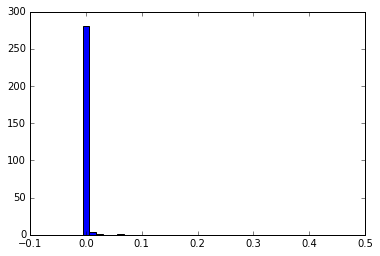

Values[0]:  280.4


In [1705]:
nans_avg = []
means_avg = []
maxs = []
stds = []
diffss = []
durations = []
for i in range(20):
    nans = 0
    diffs_m = []
    for index in np.ndindex(matrices["zero"].shape):
        #print("Index: "+str(index))
        for id_ in brain_id:
            #print id_
            data = np.zeros(nodes)-1
            brain_sig = brain_id[id_]
            #print(brain_sig)
            brain_sig = b_encoder.encode(brain_sig)
            data[-b_encoder.n:] = brain_sig

            nns[index].setIter(300)
            t0 = time.time()
            mem = nns[index].recall(data)
            duration = time.time()-t0
            durations.append(duration)
            #print("Time: %f" %duration)
            matrix_out = mem[0:m_encoder.n*reduce(lambda x, y: x*y, m_encoder.ndarray_shape)]

            matrix_decoded = m_encoder.decode_ndarray(matrix_out)
            #print("Matrix decoded:")
            #print(matrix_decoded)
            diff_m = m_encoder.decode_ndarray(m_encoder.encode_ndarray(matrices[id_][index].reshape(matrix_shape)).flatten())-matrix_decoded
            if np.isnan(diff_m):
                nans += 1
            diffs_m.append(diff_m)
            #print("diff_m: ")
            #print "Id: %s, Diff:" %id_, diff_m[0]

            brain_sig_out = mem[-b_encoder.n:]
            brain_sig_decoded = b_encoder.decode(brain_sig_out)
            #print("brain_sig decoded: ")
            #print(brain_sig_decoded)
            diff_b = b_encoder.decode(b_encoder.encode(brain_id[id_])) - brain_sig_decoded
            #print("diff_b: ")
            #print(diff_b)
            #print
#    print "nans: ", nans
#    print "mean: ", np.mean(abs(np.array(diffs_m)))
#    print "max: ", np.max(abs(np.array(diffs_m)))
#    print "std: ", np.std(abs(np.array(diffs_m)))
#    categories,values = bargraph(diffs_m,0.5,20)
    
    nans_avg.append(nans)
    means_avg.append(np.mean(abs(np.array(diffs_m))))
    maxs.append(np.max(abs(np.array(diffs_m))))
    stds.append(np.std(abs(np.array(diffs_m))))
    diffss.append(diffs_m)
print "nans: ", np.max(nans_avg)
print "mean: ", np.mean(means_avg)
print "max: ", np.max(maxs)
print "std: ", np.mean(stds)
print "duration: ", np.mean(durations)
v = []
for diff in diffss:
    categories,values = bargraph(diff,0.5,40)
    v.append(values)
plt.figure(1)
width = categories[1]
v_avg = np.mean(v,axis=0)
plt.bar(categories, np.mean(v,axis=0), width, align='center')
plt.show()
print "Values[0]: ", v_avg[0]